# Single layer models

第一个notebook是对jupyter notebook的介绍，就不多说了。我在这里重新从头开始推导一遍神经网络的建立过程。所有的内容都是从爱丁堡大学的mlp课程的github内容进行的翻译。版权归原作所有。
在这个实验中我们将会实现一个单层神经网络。这个神经网络将会包含一个完整的输入层的仿射变化。相关材料可以在这里找到原版的内容：[the slides of the first lecture](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/mlp01-intro.pdf). 

我们将会先实现一个神经网络的输入层的前向传播来产生预测值。之后会考虑如何使用用来评估结果的损失方程的梯度来计算模型参数的梯度，这个可以让我们实现一个迭代的梯度训练过程。在最后的练习中，你将会基于训练方法使用一个可互动的可视化来探究梯度的不同的超参数带来的影响。
We will first implement the forward propagation of inputs to the network to produce predicted outputs. We will then move on to considering how to use gradients of an error function evaluated on the outputs to compute the gradients with respect to the model parameters to allow us to perform an iterative gradient-descent training procedure. In the final exercise you will use an interactive visualisation to explore the role of some of the different hyperparameters of gradient-descent based training methods.

#### A note on random number generators
这是对python随机数的一个说明使用方法。

It is generally a good practice (for machine learning applications **not** for cryptography!) to seed a pseudo-random number generator once at the beginning of each experiment. This makes it easier to reproduce results as the same random draws will produced each time the experiment is run (e.g. the same random initialisations used for parameters). Therefore generally when we need to generate random values during this course, we will create a seeded random number generator object as we do in the cell below.

In [4]:
import numpy as np
seed = 27092016 #随机种子
rng = np.random.RandomState(seed)#random是可以生成随机数的一个函数，而使用随机种子是为了保证随机的结果不变
rng

## 线性和仿射变换

任何一个有限维度的向量空间的*线性变化*（也叫做线性映射）都可以被一个矩阵参数化。例如说，如果我们将$\boldsymbol{x} \in \mathbb{R}^{D}$ 看作一个D维真实值输入的空间模型，那么一个矩阵$\mathbf{W} \in \mathbb{R}^{K\times D}$就可以被用来定义一个包含一个完整的对输入的线性变化的预测模型
\begin{equation}
    \boldsymbol{y} = \mathbf{W} \boldsymbol{x}
    \qquad
    \Leftrightarrow
    \qquad
    y_k = \sum_{d=1}^D \left( W_{kd} x_d \right) \quad \forall k \in \left\lbrace 1 \dots K\right\rbrace
\end{equation}

可能看着有点恶心，对于新人来说。简单一点看，如果是标量，那么就是简单的相乘。如果w是k*d维的一个矩阵，和一个d维的x相乘，输出的就是一个k*1的vector。然后相加，就是一个k维的vector。

解释一下，这里的 $\boldsymbol{y} \in \mathbb{R}^K$ 是模型的k维的真实值输出。几何意义上，我们可以考虑一个对输入做了旋转，缩放，反射和剪的线性变化。

一个*仿射变化*包含一个线性转化和一个额外的被一个K维 vecotr b 参数化的翻译项。一个包含一个输入仿射变化的模型可以被定义为：


\begin{equation}
    \boldsymbol{y} = \mathbf{W}\boldsymbol{x} + \boldsymbol{b}
    \qquad
    \Leftrightarrow
    \qquad
    y_k = \sum_{d=1}^D \left( W_{kd} x_d \right) + b_k \quad \forall k \in \left\lbrace 1 \dots K\right\rbrace
\end{equation}

在机器学习中我们通常会用矩阵w作为一个*权重矩阵*，vector b作为一个偏置向量。
通常来说，我们不会支队单一数据向量x做处理，我们会对一批一批的数据点做处理。我们可以对每一个输入以batch的顺序做这样的计算来得到输出：

\begin{align}
    \boldsymbol{y}^{(1)} &= \mathbf{W}\boldsymbol{x}^{(1)} + \boldsymbol{b}\\
    \boldsymbol{y}^{(2)} &= \mathbf{W}\boldsymbol{x}^{(2)} + \boldsymbol{b}\\
    \dots &\\
    \boldsymbol{y}^{(B)} &= \mathbf{W}\boldsymbol{x}^{(B)} + \boldsymbol{b}\\
\end{align}

通过遍历batch的每一个输入，并计算其输出。然后在python中，普通的loop都很慢，特别是相对于C来说。这个是因为动态推断变量类型是一个很大的开销。因此，一般来说，我们会尽可能的避免使用loop，因为这个会带来非常非常大的计算开销

对于基于数字操作的数组来说，一个克服这个的方法就是向量操作。Numpy的ndarray是典型的数组，其基础的操作，就像是元素计算，线性几何运算比如说矩阵相乘或者矩阵和向量相乘，是被一个高度优化的编译库进行的。因为，如果你直接用numpy 操作来对数组执行代码而不用loop来进行，通常会得到显著的性能提升。
用一个简单的例子，我们可以考虑将两个数组a和b做一个相加的操作，并且将结果写到第三个数组c中。下面主要是对这一点进行一个例证和说明，我就不咋翻译了。

In [5]:
size = 1000
a = np.arange(size)
b = np.ones(size)

Now let's time how long it takes to add up each pair of values in the two array and write the results to a third array using a loop-based implementation. We will use the `%%timeit` magic briefly mentioned in the previous lab notebook specifying the number of times to loop the code as 100 and to give the best of 3 repeats. Run the cell below to get a print out of the average time taken.

In [6]:
%%timeit -n 100 -r 3
c = np.empty(size)
for i in range(size):
    c[i] = a[i] + b[i]

2.93 ms ± 193 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


And now we will perform the corresponding summation with the overloaded addition operator of NumPy arrays. Again run the cell below to get a print out of the average time taken.

In [7]:
%%timeit -n 100 -r 3
c = a + b

7.74 µs ± 4.95 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


The first loop-based implementation should have taken on the order of milliseconds ($10^{-3}$s) while the vectorised implementation should have taken on the order of microseconds ($10^{-6}$s), i.e. a $\sim1000\times$ speedup. Hopefully this simple example should make it clear why we want to vectorise operations whenever possible!

Getting back to our affine model, ideally rather than individually computing the output corresponding to each input we should compute the outputs for all inputs in a batch using a vectorised implementation. As you saw last week, data providers return batches of inputs as arrays of shape `(batch_size, input_dim)`. In the mathematical notation used earlier we can consider this as a matrix $\mathbf{X}$ of dimensionality $B \times D$, and in particular

\begin{equation}
    \mathbf{X} = \left[ \boldsymbol{x}^{(1)} ~ \boldsymbol{x}^{(2)} ~ \dots ~ \boldsymbol{x}^{(B)} \right]^\mathrm{T}
\end{equation}

i.e. the $b^{\textrm{th}}$ input vector $\boldsymbol{x}^{(b)}$ corresponds to the $b^{\textrm{th}}$ row of $\mathbf{X}$. If we define the $B \times K$ matrix of outputs $\mathbf{Y}$ similarly as

\begin{equation}
    \mathbf{Y} = \left[ \boldsymbol{y}^{(1)} ~ \boldsymbol{y}^{(2)} ~ \dots ~ \boldsymbol{y}^{(B)} \right]^\mathrm{T}
\end{equation}

then we can express the relationship between $\mathbf{X}$ and $\mathbf{Y}$ using [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication) and addition as

\begin{equation}
    \mathbf{Y} = \mathbf{X} \mathbf{W}^\mathrm{T} + \mathbf{B}
\end{equation}

where $\mathbf{B} = \left[ \boldsymbol{b} ~ \boldsymbol{b} ~ \dots ~ \boldsymbol{b} \right]^\mathrm{T}$ i.e. a $B \times K$ matrix with each row corresponding to the bias vector. The weight matrix needs to be transposed here as the inner dimensions of a matrix multiplication must match i.e. for $\mathbf{C} = \mathbf{A} \mathbf{B}$ then if $\mathbf{A}$ is of dimensionality $K \times L$ and $\mathbf{B}$ is of dimensionality $M \times N$ then it must be the case that $L = M$ and $\mathbf{C}$ will be of dimensionality $K \times N$.


上面是基础的矩阵知识

本次实验的第一个小练习是实现一个包含一个对输入的仿射变换的单层模型的*forward propagation* 。这个函数叫做'fprop'。在下面的cell中我们已经给出了代码。这个应该可以对`(batch_size, input_dim)`这样的batch的输入产生一个批的输出，其shape为`(batch_size, output_dim)`。
这里我们会用Numpy的‘dot’来高效的进行这个操作，这个函数的解释在：[broadcasting features](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) . If you are not familiar with either / both of these you may wish to read the [hints](#Hints:-Using-the-dot-function-and-broadcasting) section below which gives some details on these before attempting the exercise.

In [26]:
def fprop(inputs, weights, biases):
    """Forward propagates activations through the layer transformation.
    我们可以看的到这个前向传播函数非常的简单，就是对输入的一个简单的线性变化。这些注释也非常简单，可以自己看一下。
    For inputs `x`, outputs `y`, weights `W` and biases `b` the layer
    corresponds to `y = W x + b`.

    Args:
        inputs: Array of layer inputs of shape (batch_size, input_dim).
        weights: Array of weight parameters of shape 
            (output_dim, input_dim).
        biases: Array of bias parameters of shape (output_dim, ).

    Returns:
        outputs: Array of layer outputs of shape (batch_size, output_dim).
    """
    print('inputs.dot(weights.T)', inputs.dot(weights.T))
    print ('biases',biases)
    print (inputs.dot(weights.T) + biases)
    return inputs.dot(weights.T) + biases

Once you have implemented `fprop` in the cell above you can test your implementation by running the cell below.
下面这个可以对上面的实现做一个验证

In [27]:
inputs = np.array([[0., -1., 2.], [-6., 3., 1.]])
weights = np.array([[2., -3., -1.], [-5., 7., 2.]])
biases = np.array([5., -3.])
true_outputs = np.array([[6., -6.], [-17., 50.]])

if not np.allclose(fprop(inputs, weights, biases), true_outputs):
    print('Wrong outputs computed.')
else:
    print('All outputs correct!')

inputs.dot(weights.T) [[  1.  -3.]
 [-22.  53.]]
biases [ 5. -3.]
[[  6.  -6.]
 [-17.  50.]]
All outputs correct!


### Hints: Using the `dot` function and broadcasting

这里是对python的dot方程的一个简单的解释，可以自己看一下相关资料。中文应该也有

For those new to NumPy below are some details on the `dot` function and broadcasting feature of NumPy that you may want to use for implementing the first exercise. If you are already familiar with these and have already completed the first exercise you can move on straight to [second exercise](#Exercise-2:-visualising-random-models).

#### `numpy.dot` function

Matrix-matrix, matrix-vector and vector-vector (dot) products can all be computed in NumPy using the [`dot`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) function. For example if `A` and `B` are both two dimensional arrays, then `C = np.dot(A, B)` or equivalently `C = A.dot(B)` will both compute the matrix product of `A` and `B` assuming `A` and `B` have compatible dimensions. Similarly if `a` and `b` are one dimensional arrays then `c = np.dot(a, b)` (which is equivalent to `c = a.dot(b)`) will compute the [scalar / dot product](https://en.wikipedia.org/wiki/Dot_product) of the two arrays. If `A` is a two-dimensional array and `b` a one-dimensional array `np.dot(A, b)` (which is equivalent to `A.dot(b)`) will compute the matrix-vector product of `A` and `b`. Examples of all three of these product types are shown in the cell below:

In [10]:
# Initiliase arrays with arbitrary values
A = np.arange(9).reshape((3, 3))
B = np.ones((3, 3)) * 2
a = np.array([-1., 0., 1.])
b = np.array([0.1, 0.2, 0.3])
print(A.dot(B))  # Matrix-matrix product
print(B.dot(A))  # Reversed product of above A.dot(B) != B.dot(A) in general
print(A.dot(b))  # Matrix-vector product
print(b.dot(A))  # Again A.dot(b) != b.dot(A) unless A is symmetric i.e. A == A.T
print(a.dot(b))  # Vector-vector scalar product

[[  6.   6.   6.]
 [ 24.  24.  24.]
 [ 42.  42.  42.]]
[[ 18.  24.  30.]
 [ 18.  24.  30.]
 [ 18.  24.  30.]]
[ 0.8  2.6  4.4]
[ 2.4  3.   3.6]
0.2


#### Broadcasting

Another NumPy feature it will be helpful to get familiar with is [broadcasting](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html). Broadcasting allows you to apply operations to arrays of different shapes, for example to add a one-dimensional array to a two-dimensional array or multiply a multidimensional array by a scalar. The complete set of rules for broadcasting as explained in the official documentation page just linked to can sound a bit complex: you might find the [visual explanation on this page](http://www.scipy-lectures.org/intro/numpy/operations.html#broadcasting) more intuitive. The cell below gives a few examples:

In [11]:
# Initiliase arrays with arbitrary values
A = np.arange(6).reshape((3, 2))
b = np.array([0.1, 0.2])
c = np.array([-1., 0., 1.])
print(A + b)  # Add b elementwise to all rows of A
print((A.T + c).T)  # Add b elementwise to all columns of A
print(A * b)  # Multiply each row of A elementise by b 

[[ 0.1  1.2]
 [ 2.1  3.2]
 [ 4.1  5.2]]
[[-1.  0.]
 [ 2.  3.]
 [ 5.  6.]]
[[ 0.   0.2]
 [ 0.2  0.6]
 [ 0.4  1. ]]


## Exercise 2: visualising random models
对随机模型进行可视化，主要是为了帮助我们理解模型的内涵，这部分在后期再进行翻译吧

In this exercise you will use your `fprop` implementation to visualise the outputs of a single-layer affine transform model with two-dimensional inputs and a one-dimensional output. In this simple case we can visualise the joint input-output space on a 3D axis.

For this task and the learning experiments later in the notebook we will use a regression dataset from the [UCI machine learning repository](http://archive.ics.uci.edu/ml/index.html). In particular we will use a version of the [Combined Cycle Power Plant dataset](http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant), where the task is to predict the energy output of a power plant given observations of the local ambient conditions (e.g. temperature, pressure and humidity).

The original dataset has four input dimensions and a single target output dimension. We have preprocessed the dataset by [whitening](https://en.wikipedia.org/wiki/Whitening_transformation) it, a common preprocessing step. We will only use the first two dimensions of the whitened inputs (corresponding to the first two principal components of the inputs) so we can easily visualise the joint input-output space.

The dataset has been wrapped in the `CCPPDataProvider` class in the `mlp.data_providers` module and the data included as a compressed file in the data directory as `ccpp_data.npz`. Running the cell below will initialise an instance of this class, get a single batch of inputs and outputs and import the necessary `matplotlib` objects.

<IPython.core.display.Javascript object>


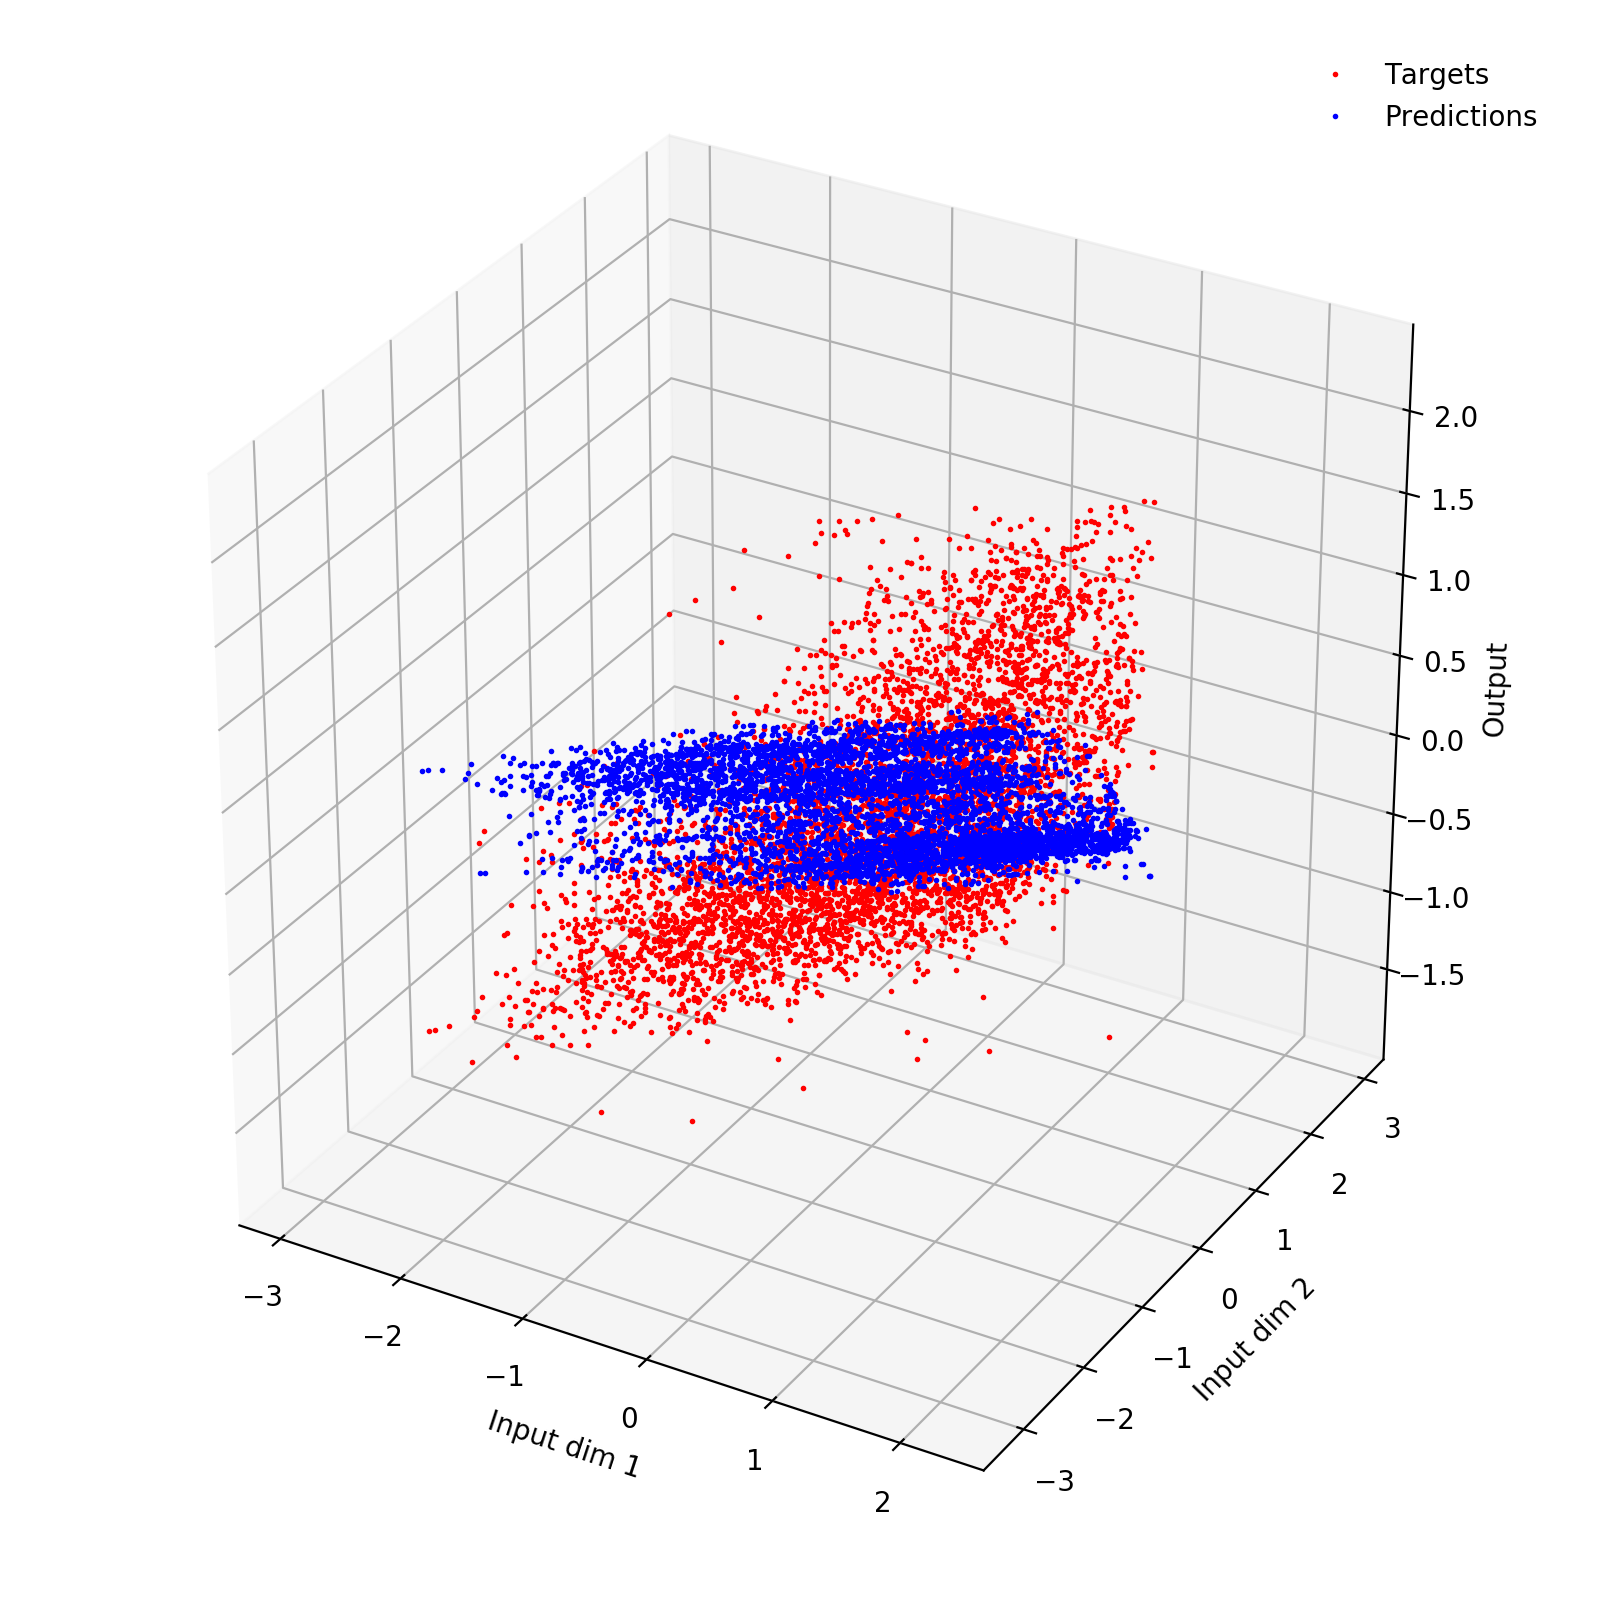

In [13]:
weights_init_range = 0.5
biases_init_range = 0.1

# Randomly initialise weights matrix
weights = rng.uniform(
    low=-weights_init_range, 
    high=weights_init_range, 
    size=(output_dim, input_dim)
)

#  Randomly initialise biases vector
biases = rng.uniform(
    low=-biases_init_range, 
    high=biases_init_range, 
    size=output_dim
)
# Calculate predicted model outputs
outputs = fprop(inputs, weights, biases)

# Plot target and predicted outputs against inputs on same axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(inputs[:, 0], inputs[:, 1], targets[:, 0], 'r.', ms=2)
ax.plot(inputs[:, 0], inputs[:, 1], outputs[:, 0], 'b.', ms=2)
ax.set_xlabel('Input dim 1')
ax.set_ylabel('Input dim 2')
ax.set_zlabel('Output')
ax.legend(['Targets', 'Predictions'], frameon=False)
fig.tight_layout()

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mlp.data_providers import CCPPDataProvider
%matplotlib notebook

data_provider = CCPPDataProvider(
    which_set='train',
    input_dims=[0, 1],
    batch_size=5000, 
    max_num_batches=1, 
    shuffle_order=False
)

input_dim, output_dim = 2, 1

inputs, targets = data_provider.next()

Here we used the `%matplotlib notebook` magic command rather than the `%matplotlib inline` we used in the previous lab as this allows us to produce interactive 3D plots which you can rotate and zoom in/out by dragging with the mouse and scrolling the mouse-wheel respectively. Once you have finished interacting with a plot you can close it to produce a static inline plot using the <i class="fa fa-power-off"></i> button in the top-right corner.

Now run the cell below to plot the predicted outputs of a randomly initialised model across the two dimensional input space as well as the true target outputs. This sort of visualisation can be a useful method (in low dimensions) to assess how well the model is likely to be able to fit the data and to judge appropriate initialisation scales for the parameters. Each time you re-run the cell a new set of random parameters will be sampled

Some questions to consider:

  * How do the weights and bias initialisation scale affect the sort of predicted input-output relationships?
  * Does the linear form of the model seem appropriate for the data here?

## Exercise 3: computing the error function and its gradient
我想这个是这次的重点，也是很多人不是很清楚的东西。计算损失函数以及它的梯度

这里我们将会讨论一个回归任务，就像我们在第一个lecture slides里面讨论过的。回归问题的主要目标是在给定输入 $\left\lbrace \boldsymbol{x}^{(n)}\right\rbrace_{n=1}^N$ 的情况下生成输出 $\left\lbrace \boldsymbol{y}^{(n)}\right\rbrace_{n=1}^N$ ，并且这个输出会尽可能的与我们的目标输出‘接近 $\left\lbrace \boldsymbol{t}^{(n)}\right\rbrace_{n=1}^N$. 衡量这个接近度的标准，或者说衡量‘距离’的标准是一个设计上的选择。

有一个很常见的选择就是计算预测值和真实值之间的平方欧式距离。这个可以通过计算目标输出和预测输出的均方误差的和得到。一个常见的方法就是将这个值乘上一个1/2。这个虽然会对计算出来的error的值造成影响，但是对于这个衡量标准来说根本不会造成影响，也就是说不会影响我们对结果的评定。而这个1/2是为了在之后求梯度的时候求导数比较方便而已。所以对每一对预测输出和真实输出的error计算如下：

\begin{equation}
    E^{(n)} = \frac{1}{2} \sum_{k=1}^K \left\lbrace \left( y^{(n)}_k - t^{(n)}_k \right)^2 \right\rbrace.
\end{equation}
而对于一批的error的计算是对每一对的误差的计算的加和
\begin{equation}
    \bar{E} = \frac{1}{N} \sum_{n=1}^N \left\lbrace E^{(n)} \right\rbrace. 
\end{equation}

我们之所以这里要做normalization，是因为在比较不同的batch或者是不同的数据集的error的时候会更有比较性（因为size可能不同）。更重要的是，这样就代表了梯度的更新大小和数据集的大小相互独立。

回归问题是去找到能够最小化E的模型参数。对我们的这个简单的单层仿射模型来说，就是去找到对应的weights $\mathbf{W}$ and biases $\boldsymbol{b}$，这些会将E最小化。

就像在lecture中提到的，对于这个简单的情况来说，有一种针对于最优化weight和bias两个参数的近似方程。这个是一个线性 least-square 解决方法。。。这个在MLPR被提到过。好吧，你们也没有上过。

然后，我们一般感兴趣的模型，并不存在一个近似形式的解决方法存在。我们因此一般会基于训练方法来使用迭代的梯度下降方法来找到能够最小化error function的参数。一个能够基于训练做到梯度下降的基础需求是能够评价error funciton的梯度。

在接下来的联系中，我们将会考虑如何计算error function对于参数$\mathbf{W}$ and $\boldsymbol{b}$的梯度。但是，我们这里的第一步是考虑error function 对于模型输出$\left\lbrace \boldsymbol{y}^{(n)}\right\rbrace_{n=1}^N$的梯度，这个可以被写成是下面的方式：

\begin{equation}
    \frac{\partial \bar{E}}{\partial \boldsymbol{y}^{(n)}} = \frac{1}{N} \left( \boldsymbol{y}^{(n)} - \boldsymbol{t}^{(n)} \right)
    \qquad \Leftrightarrow \qquad
    \frac{\partial \bar{E}}{\partial y^{(n)}_k} = \frac{1}{N} \left( y^{(n)}_k - t^{(n)}_k \right) \quad \forall k \in \left\lbrace 1 \dots K\right\rbrace
\end{equation}

PS：其实梯度就是导数。某个变量y相对于某个变量x的梯度，其实就是y对x求导。所以如果你将上面的上面的那个error function做求导就可以得到我们上面的这个方程。

例如说，error function对于输出的梯度，就是模型输出和对应的真实值之间的不同。和我们在lecture上的内容相对应。

第三个练习是使用我们上面给出的等式，来实现一个方程来计算均方误差的和的均值以及它对于模型输出的梯度。下面给出了代码。


In [14]:
def error(outputs, targets):#这个就是error function的实现，非常简单。
    """Calculates error function given a batch of outputs and targets.

    Args:
        outputs: Array of model outputs of shape (batch_size, output_dim).
        targets: Array of target outputs of shape (batch_size, output_dim).

    Returns:
        Scalar error function value.
    """
    return 0.5 * ((outputs - targets)**2).sum() / outputs.shape[0]#做了一个normalization
    
def error_grad(outputs, targets):#那么梯度的计算其实就很简单了，就是真实值和预测值的一个差值，记得需要做normalization
    """Calculates gradient of error function with respect to model outputs.

    Args:
        outputs: Array of model outputs of shape (batch_size, output_dim).
        targets: Array of target outputs of shape (batch_size, output_dim).

    Returns:
        Gradient of error function with respect to outputs
        This will be an array of shape (batch_size, output_dim).
    """
    return (outputs - targets) / outputs.shape[0]

Check your implementation by running the test cell below.

In [15]:
outputs = np.array([[1., 2.], [-1., 0.], [6., -5.], [-1., 1.]])
targets = np.array([[0., 1.], [3., -2.], [7., -3.], [1., -2.]])
true_error = 5.
true_error_grad = np.array([[0.25, 0.25], [-1., 0.5], [-0.25, -0.5], [-0.5, 0.75]])

if not error(outputs, targets) == true_error:
    print('Error calculated incorrectly.')
elif not np.allclose(error_grad(outputs, targets), true_error_grad):
    print('Error gradient calculated incorrectly.')
else:
    print('Error function and gradient computed correctly!')

Error function and gradient computed correctly!


## Exercise 4: computing gradients with respect to the parameters


接下来，在继续做对于参数的梯度计算。这个是比较重要的地方
在之前的练习中我们实现了一个方程用来计算error function相对于模型输出的梯度。对于基于训练的梯度下降来说，我们需要能够衡量error function对于模型参数的梯度。（其实就是导数而已）

使用求导的链式法则，我们可以写出error function对于single elements of the weight matrix and bias vector的偏导数
Using the [chain rule for derivatives](https://en.wikipedia.org/wiki/Chain_rule#Higher_dimensions) 

\begin{equation}
    \frac{\partial E}{\partial W_{kj}} = \sum_{n=1}^N \left\lbrace \frac{\partial E}{\partial y^{(n)}_k} \frac{\partial y^{(n)}_k}{\partial W_{kj}} \right\rbrace
    \quad \textrm{and} \quad
    \frac{\partial E}{\partial b_k} = \sum_{n=1}^N \left\lbrace \frac{\partial E}{\partial y^{(n)}_k} \frac{\partial y^{(n)}_k}{\partial b_k} \right\rbrace.
\end{equation}

所以从一开始我们对模型的定义，我们可以得到：

\begin{equation}
    y^{(n)}_k = \sum_{d=1}^D \left\lbrace W_{kd} x^{(n)}_d \right\rbrace + b_k
    \quad \Rightarrow \quad
    \frac{\partial y^{(n)}_k}{\partial W_{kj}} = x^{(n)}_j
    \quad \textrm{and} \quad
    \frac{\partial y^{(n)}_k}{\partial b_k} = 1.
\end{equation}

然后我们把他们放在一起有：

\begin{equation}
    \frac{\partial E}{\partial W_{kj}} = 
    \sum_{n=1}^N \left\lbrace \frac{\partial E}{\partial y^{(n)}_k} x^{(n)}_j \right\rbrace
    \quad \textrm{and} \quad
    \frac{\partial E}{\partial b_{k}} = 
    \sum_{n=1}^N \left\lbrace \frac{\partial E}{\partial y^{(n)}_k} \right\rbrace.
\end{equation}

尽管这个方法来得到这些结果会有一点点绕，但是这个分解的方式来求error对于参数的梯度，即依据error function对于模型输出的梯度和输出对于参数的梯度的 来求得error对于参数的梯度的方法是对于我们之后再对比较复杂的模型的梯度的求解的关键。

这一个练习的任务是实现一个方程来计算error function对于weight和bias这两个模型参数的梯度。error function对于模型输出的梯度已经被给出。实现代码如下。


In [16]:
def grads_wrt_params(inputs, grads_wrt_outputs):#从我们的公式推导中我们可以知道，error function关于参数的梯度
    #就是error function关于输出的梯度乘以输出关于参数的梯度。而输出关于参数的梯度就等于输入。所以我们就有以下的代码
    """Calculates gradients with respect to model parameters.

    Args:
        inputs: array of inputs to model of shape (batch_size, input_dim)
        grads_wrt_to_outputs: array of gradients of with respect to the model
            outputs of shape (batch_size, output_dim).

    Returns:
        list of arrays of gradients with respect to the model parameters
        `[grads_wrt_weights, grads_wrt_biases]`.
    """
    grads_wrt_weights = grads_wrt_outputs.T.dot(inputs)
    grads_wrt_biases = grads_wrt_outputs.sum(0)
    return [grads_wrt_weights, grads_wrt_biases]

Check your implementation by running the test cell below.

In [22]:
inputs = np.array([[1., 2., 3.], [-1., 4., -9.]])
grads_wrt_outputs = np.array([[-1., 1.], [2., -3.]])
true_grads_wrt_weights = np.array([[-3., 6., -21.], [4., -10., 30.]])
true_grads_wrt_biases = np.array([1., -2.])

grads_wrt_weights, grads_wrt_biases = grads_wrt_params(
    inputs, grads_wrt_outputs)
print('grads_output',grads_wrt_outputs)
print('biases',grads_wrt_biases)
if not np.allclose(true_grads_wrt_weights, grads_wrt_weights):
    print('Gradients with respect to weights incorrect.')
elif not np.allclose(true_grads_wrt_biases, grads_wrt_biases):
    print('Gradients with respect to biases incorrect.')
else:
    print('All parameter gradients calculated correctly!')

grads_output [[-1.  1.]
 [ 2. -3.]]
biases [ 1. -2.]
All parameter gradients calculated correctly!


In [29]:
np.array([[1,2],[1,2]])+np.array([1,2])#a little test of matrix add

array([[2, 4],
       [2, 4]])

## Exercise 5: wrapping the functions into reusable components
将我们之前所实现的函数打包成为一个可以重复利用的组件

在练习1，3，4中，我们实现了计算模型预测值的方法，评估了error function以及它关于输出的梯度，并在最后计算了error关于模型参数的梯度。把这些合在一起就有了模型实现基于梯度下降的迭代学习的过程所需要的所有基本要素。

尽管我们能够直接使用我们定义的函数来执行训练代码，这个也仅仅对于特定的模型结构有效。在接下来的实验中，我们将会想要使用仿射变换方程作为更加有趣的多层模型的基础。因此我们会将我们刚刚写好的实现打包成为一个可以重复使用的部件。这个部件可以在之后的课程中用来构建更加复杂的模型。

我们在下面的两个函数中将自己在上面的实现放进去，然后使用我们上面定义的两个函数在下面的代码中实现自己的单层模型。
  * In the [`mlp.layers`](/edit/mlp/layers.py) module, use your implementations of `fprop` and `grad_wrt_params` above to implement the corresponding methods in the skeleton `AffineLayer` class provided.
  * In the [`mlp.errors`](/edit/mlp/errors.py) module use your implementation of `error` and `error_grad` to implement the `__call__` and `grad` methods respectively of the skeleton `SumOfSquaredDiffsError` class provided. Note `__call__` is a special Python method that allows an object to be used with a function call syntax.

Run the cell below to use your completed `AffineLayer` and `SumOfSquaredDiffsError` implementations to train a single-layer model using batch gradient descent on the CCPP dataset.

为了便于学习，我就将所有的代码都在这里实现一遍，然后再一步一步的封装一次。

In [ ]:
def fprop (inputs, weights, biases):
    return inputs.dot(weights.T)+biases

def error(outputs, targets):#这个就是error function的实现，非常简单。
    return 0.5*((targets-outputs)**2).sum() /outputs.shape[0]
    #将目标值和预测值的均方误差求出来，然后做一个加和在做一个normalization，最后在最前面加一个1／2

def error_grad(outputs, targets):
    #这里将误差方程对预测值求导，就得出来error function对预测值的梯度
    return (targets-outputs) / outputs.shape[0]
    
def grads_wrt_params(inputs, grads_wrt_outputs):#从我们的公式推导中我们可以知道，error function关于参数的梯度
    #就是error function关于输出的梯度乘以输出关于参数的梯度。而输出关于参数的梯度就等于输入。所以我们就有以下的代码
    grads_wrt_weights=grads_wrt_outputs.T.dot(inputs)
    grads_wrt_biases=grads_wrt_outputs.sum(0)#每列自己相加生成一个一个1*outputdim的向量
    """Calculates gradients with respect to model parameters.

    Args:
        inputs: array of inputs to model of shape (batch_size, input_dim)
        grads_wrt_to_outputs: array of gradients of with respect to the model
            outputs of shape (batch_size, output_dim).

    Returns:
        list of arrays of gradients with respect to the model parameters
        `[grads_wrt_weights, grads_wrt_biases]`.
    """
    grads_wrt_weights = grads_wrt_outputs.T.dot(inputs)
    grads_wrt_biases = grads_wrt_outputs.sum(0)
    return [grads_wrt_weights, grads_wrt_biases]

In [ ]:
#

Epoch 1: 0.0s to complete
    error(train)=1.67e-01
Epoch 2: 0.0s to complete
    error(train)=9.30e-02
Epoch 3: 0.0s to complete
    error(train)=7.95e-02
Epoch 4: 0.0s to complete
    error(train)=7.71e-02
Epoch 5: 0.0s to complete
    error(train)=7.66e-02
Epoch 6: 0.0s to complete
    error(train)=7.65e-02
Epoch 7: 0.0s to complete
    error(train)=7.65e-02
Epoch 8: 0.0s to complete
    error(train)=7.65e-02
Epoch 9: 0.0s to complete
    error(train)=7.63e-02
Epoch 10: 0.0s to complete
    error(train)=7.64e-02


<IPython.core.display.Javascript object>


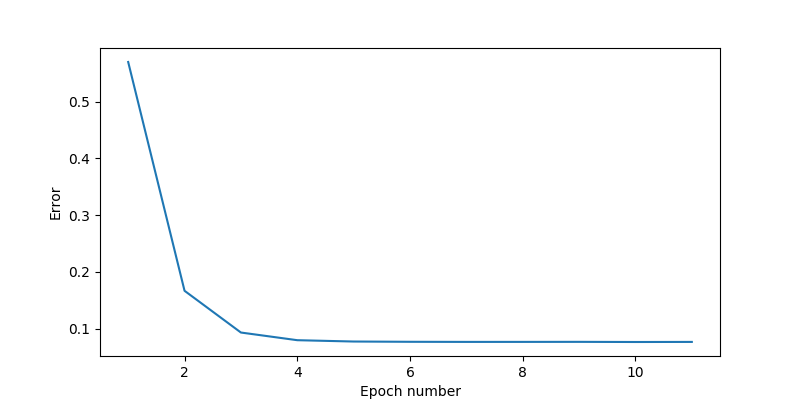

In [16]:
from mlp.layers import AffineLayer
from mlp.errors import SumOfSquaredDiffsError
from mlp.models import SingleLayerModel
from mlp.initialisers import UniformInit, ConstantInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser
import logging

# Seed a random number generator
seed = 27092016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the CCPP training set
train_data = CCPPDataProvider('train', [0, 1], batch_size=100, rng=rng)
input_dim, output_dim = 2, 1

# Create a parameter initialiser which will sample random uniform values
# from [-0.1, 0.1]
param_init = UniformInit(-0.1, 0.1, rng=rng)

# Create our single layer model
layer = AffineLayer(input_dim, output_dim, param_init, param_init)
model = SingleLayerModel(layer)

# Initialise the error object
error = SumOfSquaredDiffsError()

# Use a basic gradient descent learning rule with a small learning rate
learning_rule = GradientDescentLearningRule(learning_rate=1e-2)

# Use the created objects to initialise a new Optimiser instance.
optimiser = Optimiser(model, error, learning_rule, train_data)

# Run the optimiser for 5 epochs (full passes through the training set)
# printing statistics every epoch.
stats, keys, _ = optimiser.train(num_epochs=10, stats_interval=1)

# Plot the change in the error over training.
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(np.arange(1, stats.shape[0] + 1), stats[:, keys['error(train)']])
ax.set_xlabel('Epoch number')
ax.set_ylabel('Error')

Using similar code to previously we can now visualise the joint input-output space for the trained model. If you implemented the required methods correctly you should now see a much improved fit between predicted and target outputs when running the cell below.

<IPython.core.display.Javascript object>


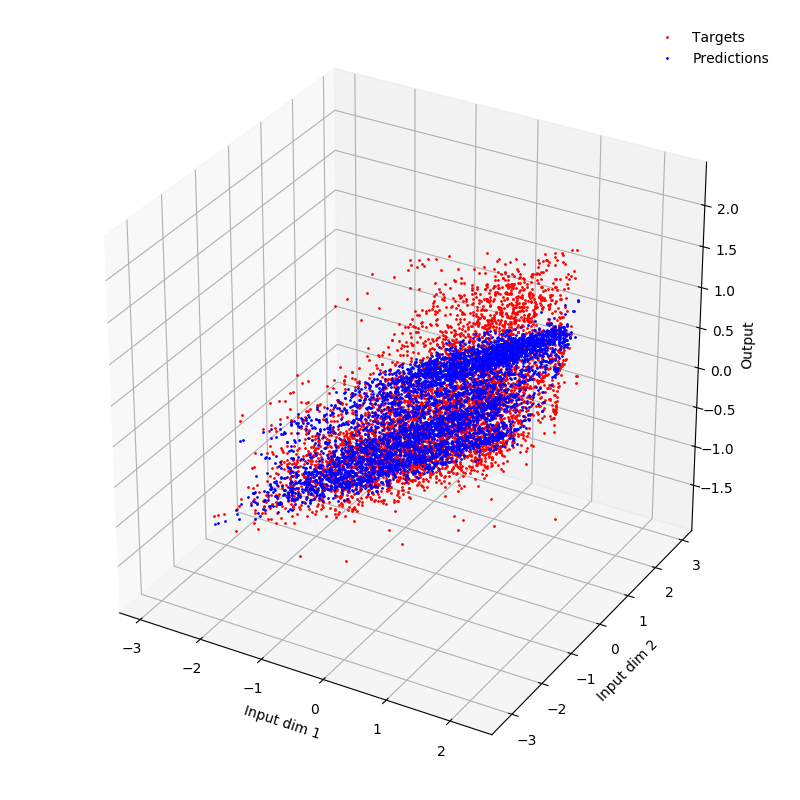

In [17]:
data_provider = CCPPDataProvider(
    which_set='train',
    input_dims=[0, 1],
    batch_size=5000, 
    max_num_batches=1, 
    shuffle_order=False
)

inputs, targets = data_provider.next()

# Calculate predicted model outputs
outputs = model.fprop(inputs)[-1]

# Plot target and predicted outputs against inputs on same axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(inputs[:, 0], inputs[:, 1], targets[:, 0], 'r.', ms=2)
ax.plot(inputs[:, 0], inputs[:, 1], outputs[:, 0], 'b.', ms=2)
ax.set_xlabel('Input dim 1')
ax.set_ylabel('Input dim 2')
ax.set_zlabel('Output')
ax.legend(['Targets', 'Predictions'], frameon=False)
fig.tight_layout()

## Exercise 6: visualising training trajectories in parameter space

Running the cell below will display an interactive widget which plots the trajectories of gradient-based training of the single-layer affine model on the CCPP dataset in the three dimensional parameter space (two weights plus bias) from random initialisations. Also shown on the right is a plot of the evolution of the error function (evaluated on the current batch) over training. By moving the sliders you can alter the training hyperparameters to investigate the effect they have on how training procedes.

Some questions to explore:

  * Are there multiple local minima in parameter space here? Why?
  * What happens to learning for very small learning rates? And very large learning rates?
  * How does the batch size affect learning?
  
**Note:** You don't need to understand how the code below works. The idea of this exercise is to help you understand the role of the various hyperparameters involved in gradient-descent based training methods.

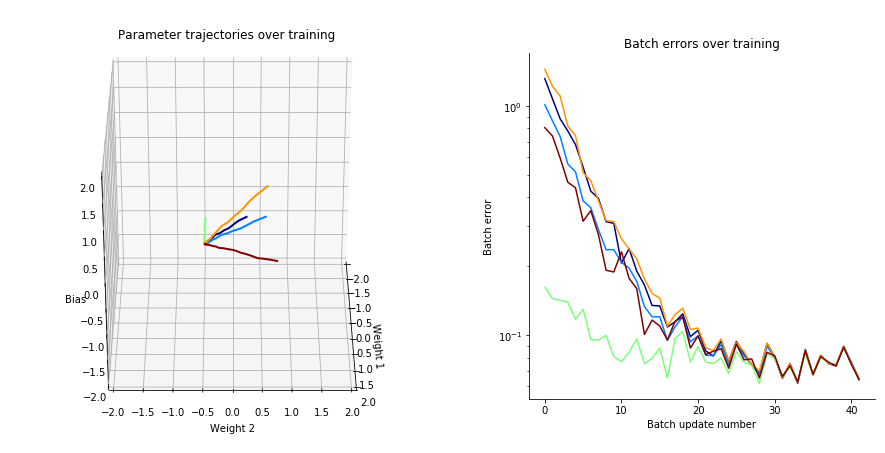

In [18]:
from ipywidgets import interact
%matplotlib inline

def setup_figure():
    # create figure and axes
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_axes([0., 0., 0.5, 1.], projection='3d')
    ax2 = fig.add_axes([0.6, 0.1, 0.4, 0.8])
    # set axes properties
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_yscale('log')
    ax1.set_xlim((-2, 2))
    ax1.set_ylim((-2, 2))
    ax1.set_zlim((-2, 2))
    #set axes labels and title
    ax1.set_title('Parameter trajectories over training')
    ax1.set_xlabel('Weight 1')
    ax1.set_ylabel('Weight 2')
    ax1.set_zlabel('Bias')
    ax2.set_title('Batch errors over training')
    ax2.set_xlabel('Batch update number')
    ax2.set_ylabel('Batch error')
    return fig, ax1, ax2

def visualise_training(n_epochs=1, batch_size=200, log_lr=-1., n_inits=5,
                       w_scale=1., b_scale=1., elev=30., azim=0.):
    fig, ax1, ax2 = setup_figure()
    # create seeded random number generator
    rng = np.random.RandomState(1234)
    # create data provider
    data_provider = CCPPDataProvider(
        input_dims=[0, 1],
        batch_size=batch_size, 
        shuffle_order=False,
    )
    learning_rate = 10 ** log_lr
    n_batches = data_provider.num_batches
    weights_traj = np.empty((n_inits, n_epochs * n_batches + 1, 1, 2))
    biases_traj = np.empty((n_inits, n_epochs * n_batches + 1, 1))
    errors_traj = np.empty((n_inits, n_epochs * n_batches))
    # randomly initialise parameters
    weights = rng.uniform(-w_scale, w_scale, (n_inits, 1, 2))
    biases = rng.uniform(-b_scale, b_scale, (n_inits, 1))
    # store initial parameters
    weights_traj[:, 0] = weights
    biases_traj[:, 0] = biases
    # iterate across different initialisations
    for i in range(n_inits):
        # iterate across epochs
        for e in range(n_epochs):
            # iterate across batches
            for b, (inputs, targets) in enumerate(data_provider):
                outputs = fprop(inputs, weights[i], biases[i])
                errors_traj[i, e * n_batches + b] = error(outputs, targets)
                grad_wrt_outputs = error_grad(outputs, targets)
                weights_grad, biases_grad = grads_wrt_params(inputs, grad_wrt_outputs)
                weights[i] -= learning_rate * weights_grad
                biases[i] -= learning_rate * biases_grad
                weights_traj[i, e * n_batches + b + 1] = weights[i]
                biases_traj[i, e * n_batches + b + 1] = biases[i]
    # choose a different color for each trajectory
    colors = plt.cm.jet(np.linspace(0, 1, n_inits))
    # plot all trajectories
    for i in range(n_inits):
        lines_1 = ax1.plot(
            weights_traj[i, :, 0, 0], 
            weights_traj[i, :, 0, 1], 
            biases_traj[i, :, 0], 
            '-', c=colors[i], lw=2)
        lines_2 = ax2.plot(
            np.arange(n_batches * n_epochs),
            errors_traj[i],
            c=colors[i]
        )
    ax1.view_init(elev, azim)
    plt.show()

w = interact(
    visualise_training,
    elev=(-90, 90, 2),
    azim=(-180, 180, 2), 
    n_epochs=(1, 5), 
    batch_size=(100, 1000, 100),
    log_lr=(-3., 1.),
    w_scale=(0., 2.),
    b_scale=(0., 2.),
    n_inits=(1, 10)
)

for child in w.widget.children:
    child.layout.width = '100%'